In [1]:
import numpy as np
from scipy.stats import norm

def area_under_norm_dist(a, b, loc, fwhm):
    # Returns area under normal distribution centered at loc with fwhm on boundary (a,b)
    # calculates CDF(b) - CDF(a) 
    sigma = fwhm / (2.0*np.sqrt(2.0*np.log(2)))  # [pixels]
    area = norm.cdf(b, loc, scale=sigma) - norm.cdf(a, loc, scale=sigma)
    return area

# Want to find photons per pixel for a given mode spacing
# define fwhm in terms of pixels, set (a,b) to pixel boundaries



I want to find the number of photons per pixel to get a grasp on the SNR. A true PDF f_z(z) should integrate to 1 over -infinity to infinity. For the purpose of this, each mode will be treated as its own PDF. When a mode is propagated through the spectrograph, it is spread out by the SLSF of the spectrograph as determined by the plate factor. This can be thought of in how many times the resolution element is being sampled or pixel sampling. A number of modes for given FSRs will be 'sent through' the spectrograph and collected on the 'detector'. The result is then multiplied by the number of photons per mode.


c:\python27\lib\site-packages\ipykernel\__main__.py:45: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python27\lib\site-packages\ipykernel\__main__.py:47: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
c:\python27\lib\site-packages\ipykernel\__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


2.7433683186e-05 506.707479097 0.0314159265359 32429.2786622


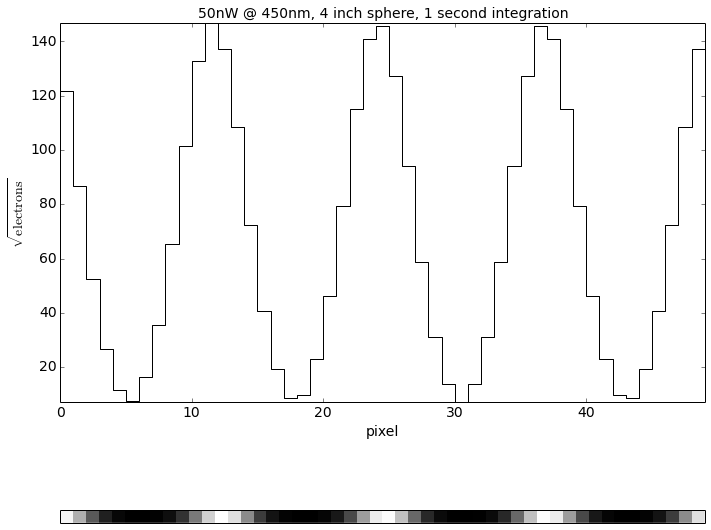

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pylab as plt

FSR = 14.0  # [GHz]
R = 150000.0
pixel_sampling = 4.0
wavelength = np.array([400, 450, 521, 600, 700])  # [nm]
plate_factor = wavelength /(pixel_sampling * R)
# del_lamb = del_nu * lambda^2 / c
# with lamba in [nm], del_nu in [GHz], c in [m s^-1], it all works out
FSR_wav = FSR * wavelength**2 / 3e8

#
# LFC parameters
#
power_per_mode = 50.0e-9  # [W]
hc_const = 1.98644582e-16  # Planck's constant * speed of light, [m^2 * nm * kg * s^-2], [W]

#
# Instrument parameters
#
instr_thruput = 0.03  # instrument throughput 
FWHM = 4.0  # pixel sampling
sphere_diameter = 4.0  # [inches]
fiber_diameter = 200  # [microns]
number_ports = 4.0  # ports in integrating sphere, assume 0.5 inch diameter
port_diameter = 0.5  # [inches]
reflectance = 0.98  # inner sphere reflectance 
As = 4.0 * np.pi * (sphere_diameter*25.4/2.0)**2  # sphere area [mm^2]
Ae = np.pi * (fiber_diameter*0.001/2.0)**2  # fiber area within sphere [mm^2]
Ap = number_ports * np.pi * ((port_diameter*25.4)/2.0)**2  # total port area within sphere [mm^2]
int_sphere = (Ae/As) / (1-reflectance*(1-(Ap/As)))   # integrating sphere throughput
print int_sphere, Ap, Ae, As

# E_ph = h * nu = h * c * lambda^-1
# Photons per second = Power / E_ph
Nphs = power_per_mode / (hc_const / wavelength)

ind = 1  # wavelength selector
n_pixels = 50.
pixels = np.arange(0, n_pixels)
loc = pixels * FSR_wav[ind] / plate_factor[ind]  # location of maximums
det = np.zeros(n_pixels)
for n in pixels:
    det[n] = np.sum(area_under_norm_dist(n, n+1, loc, pixel_sampling))


det *= Nphs[ind] * instr_thruput * int_sphere

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (10, 10))
title = "%dnW @ %dnm, %d inch sphere, 1 second integration" % (power_per_mode*1e9, wavelength[ind], sphere_diameter)
axes[0].set_title(title, fontsize=14)

axes[0].step(pixels, np.sqrt(det), 'k')
axes[0].set_xlabel('pixel', size=14)
plt.setp(axes[0].get_xticklabels(), fontsize=14)
axes[0].set_ylabel('$\sqrt{\mathrm{electrons}}$', size=14)
plt.setp(axes[0].get_yticklabels(), fontsize=14)
axes[0].axis('tight')

axes[1].imshow(det.reshape(1, n_pixels), cmap='gray', interpolation='none')
axes[1].get_yaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.tight_layout()
plt.savefig('LFCthroughput.pdf', format='pdf')

